# Challenge

The goal of this challenge is to predict the high impact incidents.

### Table of Contents

0. [Data loading](#data_loading)
1. [Missing values treatment](#missing_values)
2. [Exploratory Data Analysis](#eda)
3. [Feature Engineering](#fe)
4. [Modeling](#ml)
5. [Evaluation](#eval)
6. [Conclusions](#conclussions)

## 0. Data loading <a class="anchor" id="data_loading"></a>

In [92]:
# data wrangling
import pandas as pd
import numpy as np

# timestamp
import datetime

# data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt

# Data preprocessing
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# ML models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb
import catboost as ctb

# feature importance
import shap

# setting the rows and columns display
pd.options.display.max_columns = 50
pd.options.display.max_rows = 50
pd.set_option('display.max_rows', 500)

We read the data.

In [93]:
data = pd.read_csv("data.csv")

We drop the first column and the target variable.

In [94]:
X = data.drop(columns = ['Unnamed: 0'])
y = data["impact"]

In [95]:
X.shape

(99198, 25)

In [96]:
X.head(5)

,ID,ID_status,active,count_reassign,count_opening,count_updated,ID_caller,opened_by,opened_time,Created_by,created_at,updated_by,updated_at,type_contact,location,category_ID,user_symptom,Support_group,support_incharge,Doc_knowledge,confirmation_check,impact,notify,problem_ID,change_request
0,INC0000045,New,True,0,0,0,Caller 2403,Opened by 8,29-02-2016 01:16,Created by 6,29-02-2016 01:23,Updated by 21,29-02-2016 01:23,Phone,Location 143,Category 55,Symptom 72,Group 56,?,True,False,2 - Medium,Do Not Notify,?,?
1,INC0000045,Resolved,True,0,0,3,Caller 2403,Opened by 8,29-02-2016 01:16,Created by 6,29-02-2016 01:23,Updated by 804,29-02-2016 11:29,Phone,Location 143,Category 55,Symptom 72,Group 56,?,True,False,2 - Medium,Do Not Notify,?,?
2,INC0000045,Closed,False,0,0,4,Caller 2403,Opened by 8,29-02-2016 01:16,Created by 6,29-02-2016 01:23,Updated by 908,5/3/2016 12:00,Phone,Location 143,Category 55,Symptom 72,Group 56,?,True,False,2 - Medium,Do Not Notify,?,?
3,INC0000047,Active,True,1,0,1,Caller 2403,Opened by 397,29-02-2016 04:40,Created by 171,29-02-2016 04:57,Updated by 21,29-02-2016 05:30,Phone,Location 165,Category 40,Symptom 471,Group 24,Resolver 31,True,False,2 - Medium,Do Not Notify,?,?
4,INC0000047,Active,True,1,0,2,Caller 2403,Opened by 397,29-02-2016 04:40,Created by 171,29-02-2016 04:57,Updated by 21,29-02-2016 05:33,Phone,Location 165,Category 40,Symptom 471,Group 24,Resolver 31,True,False,2 - Medium,Do Not Notify,?,?


In [97]:
X.columns

Index(['ID', 'ID_status', 'active', 'count_reassign', 'count_opening',
       'count_updated', 'ID_caller', 'opened_by', 'opened_time', 'Created_by',
       'created_at', 'updated_by', 'updated_at', 'type_contact', 'location',
       'category_ID', 'user_symptom', 'Support_group', 'support_incharge',
       'Doc_knowledge', 'confirmation_check', 'impact', 'notify', 'problem_ID',
       'change_request'],
      dtype='object')

We see that we have values marked with **"?"**, which are in fact missing values. There we will replace them with **NaN**, then treating them accordingly.

In [98]:
X.replace({"?":np.nan}, inplace = True)

Now we split the data into train and test sets.

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle = True, stratify = y)

## 1. Missing values treatment <a class="anchor" id="missing_values"></a>

In this section we will focus on the missing values from the training set. After we will handle them we will treat the values from the test set using the values used on the training set.

In [100]:
X_train.isnull().sum()/len(X_train)*100

ID                     0.000000
ID_status              0.000000
active                 0.000000
count_reassign         0.000000
count_opening          0.000000
count_updated          0.000000
ID_caller              0.017282
opened_by              3.306547
opened_time            0.000000
Created_by            37.542844
created_at            37.542844
updated_by             0.000000
updated_at             0.000000
type_contact           0.000000
location               0.056165
category_ID            0.059045
user_symptom          23.070941
Support_group          9.987327
support_incharge      19.394280
Doc_knowledge          0.000000
confirmation_check     0.000000
impact                 0.000000
notify                 0.000000
problem_ID            98.431694
change_request        99.301535
dtype: float64

We can see that we have missing values in different percentage. 
1. The variables **ID_caller**, **opened_by**, **location** and **category_ID** have less than 5% missing values. Therefore we will use imputation with the most frequent value (mode) for each variable. 
2. The variables **problem_ID** and **change_request** have almost 70% missing values and subsequently we will drop them. 
3. Next we will look closer to the remaining variables, namely **Created_by**, **created_at**, **user_symptom**, **Suport_group** and **support_incharge**.

In the end we will input the missing values using the values we used for train set.

#### 1. ID_caller, opened_by, location and category_ID

In [101]:
# We create a list with the columns whose missing values percentage is less than 5%
missing = ["ID_caller", "opened_by", "location", "category_ID"]

# We will replace the missing values with the most frequent value (mode) for each variable
for column in missing:
    X_train[column].fillna(X_train[column].mode()[0], inplace = True)
    
    # we replace the missing values in the test set with the values we used in the train set
    X_test[column].fillna(X_train[column].mode()[0], inplace = True)

#### 2. problem_ID and change_request

In [102]:
# We drop the columns whose missing value percentage is greater than 70% in the train set
X_train.drop(columns = ["problem_ID", "change_request"], inplace = True)

# We drop the columns whose missing value percentage is greater than 70% in the test set
X_test.drop(columns = ["problem_ID", "change_request"], inplace = True)

#### 3. Created_by, created_at, user_symptom, Suport_group and support_incharge

Now we will take a closer look to these variables. As we can see above, the variables **Created_by** and **created_at** have exactly the same percentage of missing values. Lets check if those values have a one-to-one corespondece.

In [103]:
X_train[X_train["Created_by"].isnull()][['Created_by', "created_at"]].nunique()

Created_by    0
created_at    0
dtype: int64

They are indeed related. We will replace the missing values from **Created_by** with a new label called *Created_by -1*.

In [104]:
# We replace the missing values for train set
X_train['Created_by'].fillna("Created by -1", inplace = True)

# We replace the missing values for train set
X_test['Created_by'].fillna("Created by -1", inplace = True)

As to the variable **created_at**, lets notice first that it is a timestamp and it is related to the variables **opened_time** and **updated_at**.

These variables are carry on valuable information, as we can extract:
- the day of the week/ working days - weekend days
- the month/ season
- the time in hours and minutes
- year

Lets take a look at those 3 columns together, excluding the missing values from **created_at**.

In [105]:
X_train[X_train["created_at"].isnull() == False][["opened_time", "created_at", "updated_at"]]

,opened_time,created_at,updated_at
64226,25-04-2016 09:10,25-04-2016 09:19,25-04-2016 11:40
30500,22-03-2016 08:45,22-03-2016 09:28,23-03-2016 13:04
20516,14-03-2016 10:49,14-03-2016 10:54,12/4/2016 14:59
2678,2/3/2016 8:16,2/3/2016 8:18,2/3/2016 9:25
84534,13-05-2016 22:50,13-05-2016 22:51,13-05-2016 22:51
...,...,...,...
2859,2/3/2016 9:05,2/3/2016 9:07,2/3/2016 10:24
33164,23-03-2016 17:01,23-03-2016 17:06,23-03-2016 17:06
34084,24-03-2016 13:13,24-03-2016 13:41,1/4/2016 14:26
25228,16-03-2016 20:29,16-03-2016 20:34,21-03-2016 09:35


Firstly we see that the event of incident system creation is between the **opened_time** and **updated_at**. This gives us an idea of what values we can use to replace the missing timestamps. Now we will now convert those 3 variables into timestamps.

In [106]:
# We convert the columns in the train set to timestamp type
X_train["opened_time"] = pd.to_datetime(X_train["opened_time"])
X_train["created_at"] = pd.to_datetime(X_train["created_at"])
X_train["updated_at"] = pd.to_datetime(X_train["updated_at"])

# We convert the columns in the test set to timestamp type
X_test["opened_time"] = pd.to_datetime(X_test["opened_time"])
X_test["created_at"] = pd.to_datetime(X_test["created_at"])
X_test["updated_at"] = pd.to_datetime(X_test["updated_at"])

Now we will take the difference between the time the incidents were created and the time the incidents were opened.

In [107]:
diff_open_create = pd.DataFrame(X_train[X_train["created_at"].isnull()==False]["created_at"] - X_train[X_train["created_at"].isnull()==False]["opened_time"])

Now lets see some statistics.

In [108]:
diff_open_create.describe()

,0
count,43369
mean,0 days 00:04:10.886577970
std,1 days 06:54:02.496036841
min,-147 days +19:06:00
25%,0 days 00:03:00
50%,0 days 00:06:00
75%,0 days 00:11:00
max,30 days 00:23:00


On average, an incident is created after 4:10 minutes after was opened. We can also see that there is at least one situation in which the incident was first created, then opened.

Now we will do the same with the updated_at and created_at.

In [109]:
diff_updated_created = X_train[X_train["created_at"].isnull()==False]["updated_at"] - X_train[X_train["created_at"].isnull()==False]["created_at"]

In [110]:
diff_updated_created.describe()

count                         43369
mean      5 days 20:06:02.790472457
std      77 days 23:04:42.686921099
min             -305 days +20:22:00
25%                 0 days 00:00:00
50%                 0 days 03:27:00
75%                12 days 03:20:00
max               603 days 15:16:00
dtype: object

On average, an incident is updated after 5 days and 20:06 hours. We can also see that this mean is influenced by extreme outliers (an incident was updated after 603 days and 15:16 hours) and the median value is 3:27 hours. Therefore we will use the **opened_date** variable to fill the missing values for **created_at** by adding the average time we found.

In [111]:
X_train["created_at"].fillna(X_train['opened_time'] + datetime.timedelta(minutes = 4, seconds = 10), inplace = True)

In [112]:
X_test["created_at"].fillna(X_test['opened_time'] + datetime.timedelta(minutes = 4, seconds = 10), inplace = True)

#### 4. user_symptom

Similarly to what we have done to **Create_by** variable, we will replace the missing values with a new label called *Symptom -1*.

In [113]:
X_train["user_symptom"].fillna("Symptom -1", inplace = True)

X_test["user_symptom"].fillna("Symptom -1", inplace = True)

#### 5. Support_group

In [114]:
X_train["Support_group"].isnull().sum()

6935

In [115]:
# replace the missing values with the label "Group -1" in the training set
X_train["Support_group"].fillna("Group -1", inplace = True)

# replace the missing values with the label "Group -1" in the test set
X_test["Support_group"].fillna("Group -1", inplace = True)

#### 6. support_incharge

In [116]:
X_train["support_incharge"].isnull().sum()

13467

In [117]:
# replace the missing values with the label "Resolver -1" in the training set
X_train["support_incharge"].fillna("Resolver -1", inplace = True)

# replace the missing values with the label "Resolver -1" in the training set
X_test["support_incharge"].fillna("Resolver -1", inplace = True)

One last check before moving further.

In [118]:
X_train.isnull().sum()

ID                    0
ID_status             0
active                0
count_reassign        0
count_opening         0
count_updated         0
ID_caller             0
opened_by             0
opened_time           0
Created_by            0
created_at            0
updated_by            0
updated_at            0
type_contact          0
location              0
category_ID           0
user_symptom          0
Support_group         0
support_incharge      0
Doc_knowledge         0
confirmation_check    0
impact                0
notify                0
dtype: int64

In [119]:
X_test.isnull().sum()

ID                    0
ID_status             0
active                0
count_reassign        0
count_opening         0
count_updated         0
ID_caller             0
opened_by             0
opened_time           0
Created_by            0
created_at            0
updated_by            0
updated_at            0
type_contact          0
location              0
category_ID           0
user_symptom          0
Support_group         0
support_incharge      0
Doc_knowledge         0
confirmation_check    0
impact                0
notify                0
dtype: int64

## 2. Exploratory Data Analysis <a class="anchor" id="eda"></a>

Now we will learn more about our data. At this point we will explore only the training set, because in the real world we do not know how the unseen will look like. 

Further, we will have a look at the numbers of unique values for each variable. If a column has too many labels we should inspect the frequency of those labels. Labels that have very few occurences can be grouped into a new label.

In [120]:
X_train.nunique()

ID                    23180
ID_status                 9
active                    2
count_reassign           25
count_opening             9
count_updated           110
ID_caller              5125
opened_by               206
opened_time           18682
Created_by              185
created_at            20535
updated_by              640
updated_at            35629
type_contact              5
location                224
category_ID              54
user_symptom            500
Support_group            76
support_incharge        229
Doc_knowledge             2
confirmation_check        2
impact                    3
notify                    2
dtype: int64

#### 1. Impact

This is our target variable. Since our goal is to predict the incidents with high impact, we could group the medium and low incidents into a single label called "not high" and transform this multiclassification problem into a binary one.

<AxesSubplot:xlabel='impact', ylabel='count'>

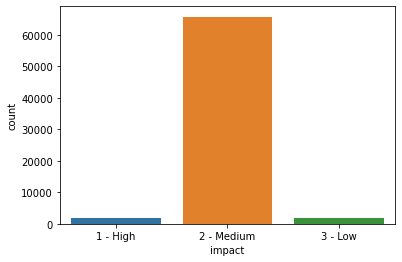

In [121]:
sns.countplot(data = X_train, x = "impact")

In [122]:
X_train["impact"].value_counts() / len(X_train) * 100

2 - Medium    94.793917
3 - Low        2.742014
1 - High       2.464069
Name: impact, dtype: float64

We can see that the majority of incidents are categorized as medium, whereas the high and low impact incidents are in minority.

#### 2. ID_status

[Text(0, 0, 'Active'),
 Text(1, 0, 'New'),
 Text(2, 0, 'Awaiting Problem'),
 Text(3, 0, 'Resolved'),
 Text(4, 0, 'Closed'),
 Text(5, 0, 'Awaiting User Info'),
 Text(6, 0, 'Awaiting Evidence'),
 Text(7, 0, 'Awaiting Vendor')]

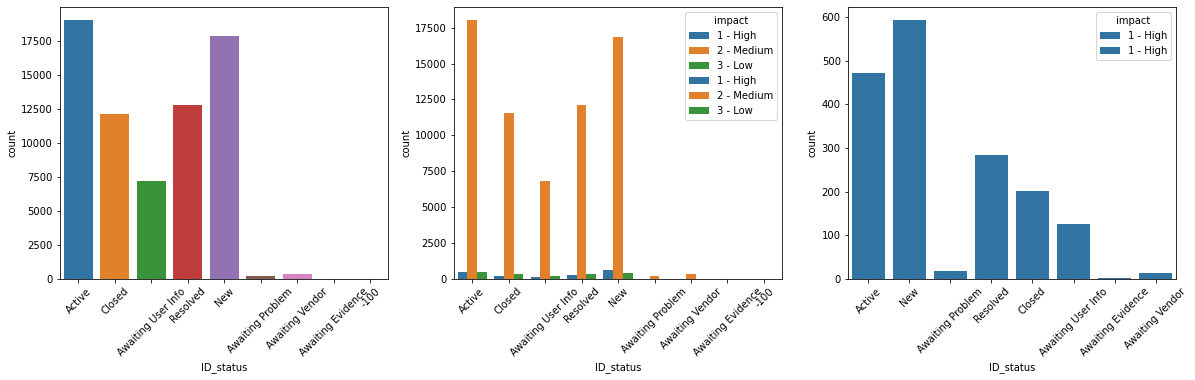

In [123]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
sns.countplot(data = X_train, x = "ID_status", ax = axes[0]).set_xticklabels(sns.countplot(data = X_train, x = "ID_status", ax = axes[0]).get_xticklabels(), rotation=45)
sns.countplot(data = X_train, x = "ID_status", hue = "impact", ax = axes[1]).set_xticklabels(sns.countplot(data = X_train, x = "ID_status", hue = "impact", ax = axes[1]).get_xticklabels(), rotation=45)
sns.countplot(data = X_train[X_train["impact"] == '1 - High'], x = "ID_status", hue = "impact", ax = axes[2]).set_xticklabels(sns.countplot(data = X_train[X_train["impact"] == '1 - High'], x = "ID_status", hue = "impact", ax = axes[2]).get_xticklabels(), rotation=45)

We see that we have 5 major ID statuses and other 4 minor categories. We can group the minor categories into a new category called "Others".

#### 3. active

<AxesSubplot:xlabel='active', ylabel='count'>

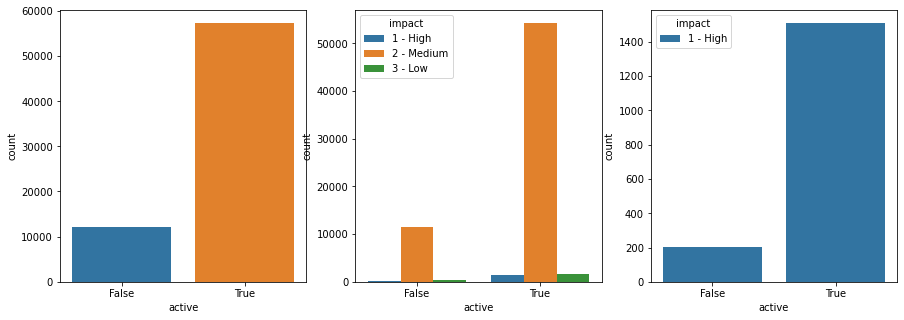

In [124]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.countplot(data = X_train, x = "active", ax = axes[0])
sns.countplot(data = X_train, x = "active", hue = "impact", ax = axes[1])
sns.countplot(data = X_train[X_train["impact"] == '1 - High'], x = "active", hue = "impact", ax = axes[2])

We see that the majority of incidents are active.

#### 4. count_reasign

<AxesSubplot:xlabel='count_reassign', ylabel='count'>

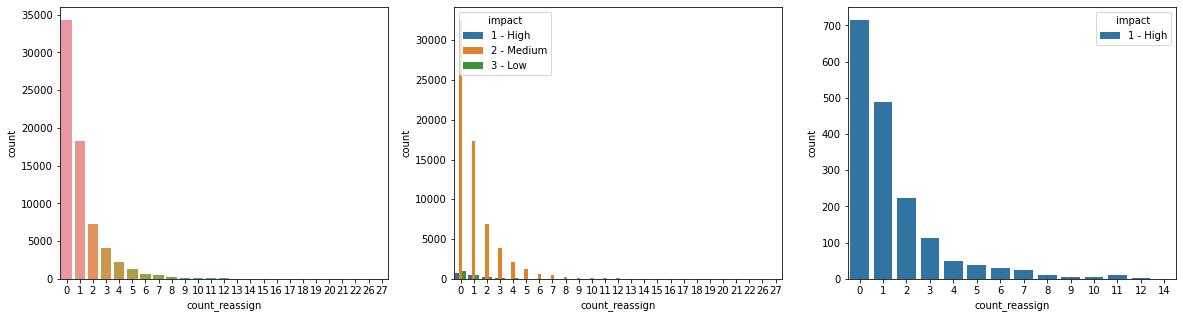

In [125]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
sns.countplot(data = X_train, x = "count_reassign", ax = axes[0])
sns.countplot(data = X_train, x = "count_reassign", hue = "impact", ax = axes[1])
sns.countplot(data = X_train[X_train["impact"] == '1 - High'], x = "count_reassign", hue = "impact", ax = axes[2])

We can see that the number of times of the incidents changed is concentrated around 0 and drastically decreases. As there are many values with low frequency, we can use a threshold to regroup the other values that have low frequency into a single category. For example, we can choose to regroup all the values after 8 times in a label called "8+".

#### 5. count_opening

<AxesSubplot:xlabel='count_opening', ylabel='count'>

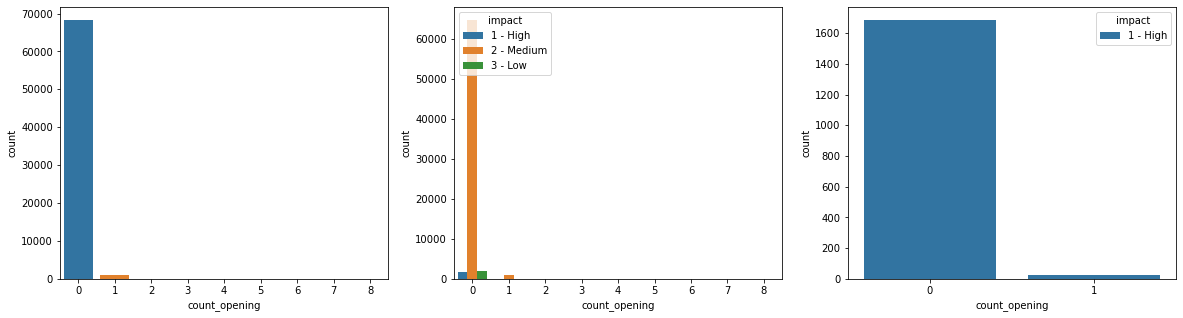

In [126]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
sns.countplot(data = X_train, x = "count_opening", ax = axes[0])
sns.countplot(data = X_train, x = "count_opening", hue = "impact", ax = axes[1])
sns.countplot(data = X_train[X_train["impact"] == '1 - High'], x = "count_opening", hue = "impact", ax = axes[2])

In this case we only have one dominant value and 7 other rare labels. We can transform the minority labels into a new label called 'other'. This transformation's meaning is that we are no longer interested in how many times the incident resolution was rejected by the caller. We only want to know whether was rejected or not.

#### 6. count_updated

<AxesSubplot:xlabel='count_updated', ylabel='Count'>

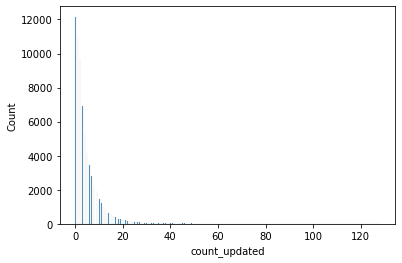

In [127]:
sns.histplot(data = X_train, x = "count_updated")

We can see that the number of updates concentrate between 0 and 20, then gradually decrease.

#### 7. Features with high cardinality (ID_caller, Created_by, opened_by, user_symptom, location, ID_status)

These variables have high cardinality and the labels with few occurences can be grouped into a new label. 

Now, for each variable, we will look at:
1. the top 10 most frequent occurences overall, 
1. the top 10 most frequent occurences grouped by impact (it is a more granular plot than the above)
3. the top 10 most frequent occurences for high impact incidents (different from those above)

#### 7.1. Location

In [128]:
top10_loc = list(X_train["location"].value_counts()[:10].index)
top10_loc_high = list(X_train[X_train["impact"] == "1 - High"]["location"].value_counts()[:10].index)

[Text(0, 0, 'Location 204'),
 Text(1, 0, 'Location 161'),
 Text(2, 0, 'Location 143'),
 Text(3, 0, 'Location 96'),
 Text(4, 0, 'Location 108'),
 Text(5, 0, 'Location 93'),
 Text(6, 0, 'Location 179'),
 Text(7, 0, 'Location 41'),
 Text(8, 0, 'Location 55'),
 Text(9, 0, 'Location 51')]

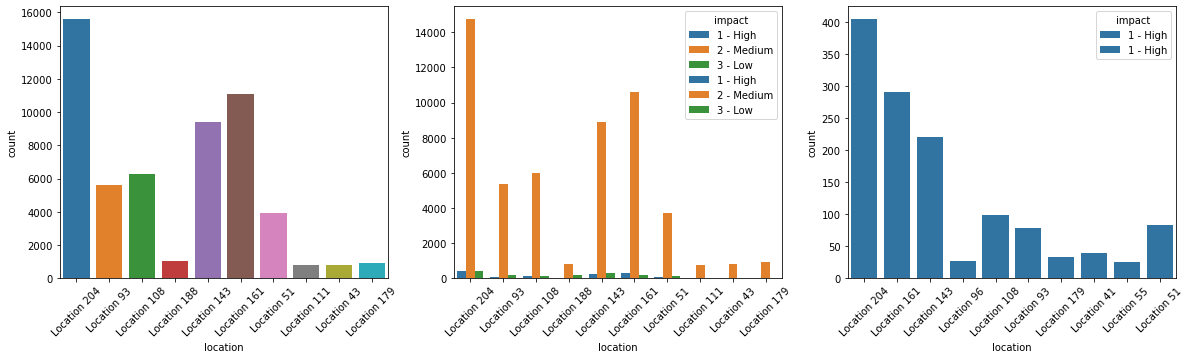

In [129]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
sns.countplot(data = X_train.loc[X_train['location'].isin(top10_loc)], x = "location", ax = axes[0]).set_xticklabels(sns.countplot(data = X_train.loc[X_train['location'].isin(top10_loc)], x = "location", ax = axes[0]).get_xticklabels(), rotation=45)
sns.countplot(data = X_train.loc[X_train['location'].isin(top10_loc)], x = "location", hue = "impact", ax = axes[1]).set_xticklabels(sns.countplot(data = X_train.loc[X_train['location'].isin(top10_loc)], x = "location", hue = "impact", ax = axes[1]).get_xticklabels(), rotation=45)
sns.countplot(data = X_train[X_train["impact"] == "1 - High"].loc[X_train['location'].isin(top10_loc_high)], x = "location", hue = "impact", ax = axes[2]).set_xticklabels(sns.countplot(data = X_train[X_train["impact"] == "1 - High"].loc[X_train['location'].isin(top10_loc_high)], x = "location", hue = "impact", ax = axes[2]).get_xticklabels(), rotation=45)

#### 7.2. ID

In [130]:
top10_id = list(X_train["ID"].value_counts()[:10].index)
top10_id_high = list(X_train[X_train["impact"] == "1 - High"]["ID"].value_counts()[:10].index)

[Text(0, 0, 'INC0033506'),
 Text(1, 0, 'INC0005226'),
 Text(2, 0, 'INC0003092'),
 Text(3, 0, 'INC0023942'),
 Text(4, 0, 'INC0025734'),
 Text(5, 0, 'INC0026422'),
 Text(6, 0, 'INC0003256'),
 Text(7, 0, 'INC0006210'),
 Text(8, 0, 'INC0025714'),
 Text(9, 0, 'INC0026304')]

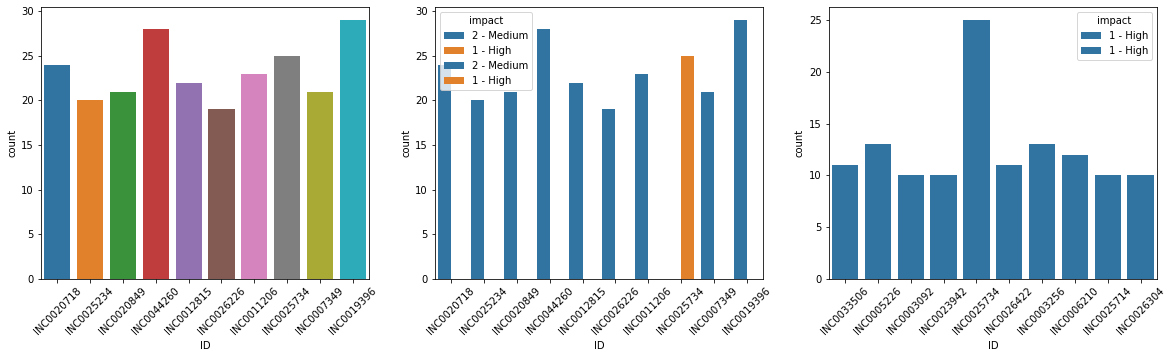

In [131]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
sns.countplot(data = X_train.loc[X_train['ID'].isin(top10_id)], x = "ID", ax = axes[0]).set_xticklabels(sns.countplot(data = X_train.loc[X_train['ID'].isin(top10_id)], x = "ID", ax = axes[0]).get_xticklabels(), rotation=45)
sns.countplot(data = X_train.loc[X_train['ID'].isin(top10_id)], x = "ID", hue = "impact", ax = axes[1]).set_xticklabels(sns.countplot(data = X_train.loc[X_train['ID'].isin(top10_id)], x = "ID", hue = "impact", ax = axes[1]).get_xticklabels(), rotation=45)
sns.countplot(data = X_train[X_train["impact"] == "1 - High"].loc[X_train['ID'].isin(top10_id_high)], x = "ID", hue = "impact", ax = axes[2]).set_xticklabels(sns.countplot(data = X_train[X_train["impact"] == "1 - High"].loc[X_train['ID'].isin(top10_id_high)], x = "ID", hue = "impact", ax = axes[2]).get_xticklabels(), rotation=45)

#### 7.3. ID_caller

In [132]:
top10_idc = list(X_train["ID_caller"].value_counts()[:10].index)
top10_idc_high = list(X_train[X_train["impact"] == "1 - High"]["ID_caller"].value_counts()[:10].index)

[Text(0, 0, 'Caller 2001'),
 Text(1, 0, 'Caller 2491'),
 Text(2, 0, 'Caller 93'),
 Text(3, 0, 'Caller 4036'),
 Text(4, 0, 'Caller 3352'),
 Text(5, 0, 'Caller 5344'),
 Text(6, 0, 'Caller 1847'),
 Text(7, 0, 'Caller 1441'),
 Text(8, 0, 'Caller 5197'),
 Text(9, 0, 'Caller 3628')]

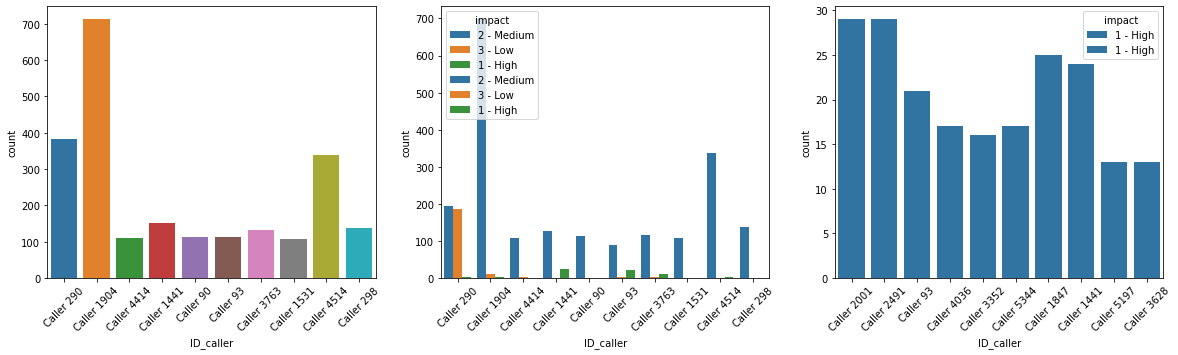

In [133]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
sns.countplot(data = X_train.loc[X_train['ID_caller'].isin(top10_idc)], x = "ID_caller", ax = axes[0]).set_xticklabels(sns.countplot(data = X_train.loc[X_train['ID_caller'].isin(top10_idc)], x = "ID_caller", ax = axes[0]).get_xticklabels(), rotation=45)
sns.countplot(data = X_train.loc[X_train['ID_caller'].isin(top10_idc)], x = "ID_caller", hue = "impact", ax = axes[1]).set_xticklabels(sns.countplot(data = X_train.loc[X_train['ID_caller'].isin(top10_idc)], x = "ID_caller", hue = "impact", ax = axes[1]).get_xticklabels(), rotation=45)
sns.countplot(data = X_train[X_train["impact"] == "1 - High"].loc[X_train['ID_caller'].isin(top10_idc_high)], x = "ID_caller", hue = "impact", ax = axes[2]).set_xticklabels(sns.countplot(data = X_train[X_train["impact"] == "1 - High"].loc[X_train['ID_caller'].isin(top10_idc_high)], x = "ID_caller", hue = "impact", ax = axes[2]).get_xticklabels(), rotation=45)

#### 7.4. Created_by

In [134]:
top10_idcrt = list(X_train["Created_by"].value_counts()[:10].index)
top10_idcrt_high = list(X_train[X_train["impact"] == "1 - High"]["Created_by"].value_counts()[:10].index)

[Text(0, 0, 'Created by -1'),
 Text(1, 0, 'Created by 31'),
 Text(2, 0, 'Created by 81'),
 Text(3, 0, 'Created by 171'),
 Text(4, 0, 'Created by 45'),
 Text(5, 0, 'Created by 13'),
 Text(6, 0, 'Created by 6'),
 Text(7, 0, 'Created by 169'),
 Text(8, 0, 'Created by 10'),
 Text(9, 0, 'Created by 20')]

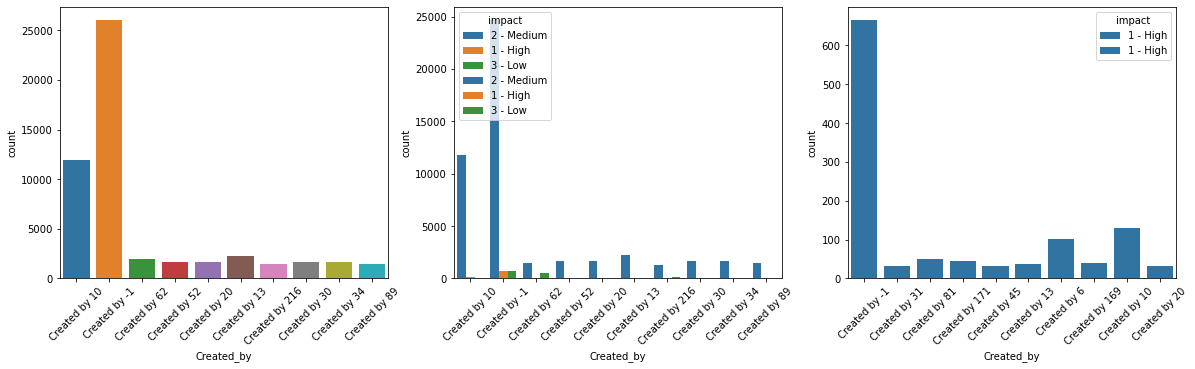

In [135]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
sns.countplot(data = X_train.loc[X_train['Created_by'].isin(top10_idcrt)], x = "Created_by", ax = axes[0]).set_xticklabels(sns.countplot(data = X_train.loc[X_train['Created_by'].isin(top10_idcrt)], x = "Created_by", ax = axes[0]).get_xticklabels(), rotation=45)
sns.countplot(data = X_train.loc[X_train['Created_by'].isin(top10_idcrt)], x = "Created_by", hue = "impact", ax = axes[1]).set_xticklabels(sns.countplot(data = X_train.loc[X_train['Created_by'].isin(top10_idcrt)], x = "Created_by", hue = "impact", ax = axes[1]).get_xticklabels(), rotation=45)
sns.countplot(data = X_train[X_train["impact"] == "1 - High"].loc[X_train['Created_by'].isin(top10_idcrt_high)], x = "Created_by", hue = "impact", ax = axes[2]).set_xticklabels(sns.countplot(data = X_train[X_train["impact"] == "1 - High"].loc[X_train['Created_by'].isin(top10_idcrt_high)], x = "Created_by", hue = "impact", ax = axes[2]).get_xticklabels(), rotation=45)

#### 7.5. opened_by

In [136]:
top10_idopt = list(X_train["opened_by"].value_counts()[:10].index)
top10_idopt_high = list(X_train[X_train["impact"] == "1 - High"]["opened_by"].value_counts()[:10].index)

[Text(0, 0, 'Opened by  17'),
 Text(1, 0, 'Opened by  58'),
 Text(2, 0, 'Opened by  180'),
 Text(3, 0, 'Opened by  397'),
 Text(4, 0, 'Opened by  94'),
 Text(5, 0, 'Opened by  24'),
 Text(6, 0, 'Opened by  8'),
 Text(7, 0, 'Opened by  390'),
 Text(8, 0, 'Opened by  40'),
 Text(9, 0, 'Opened by  108')]

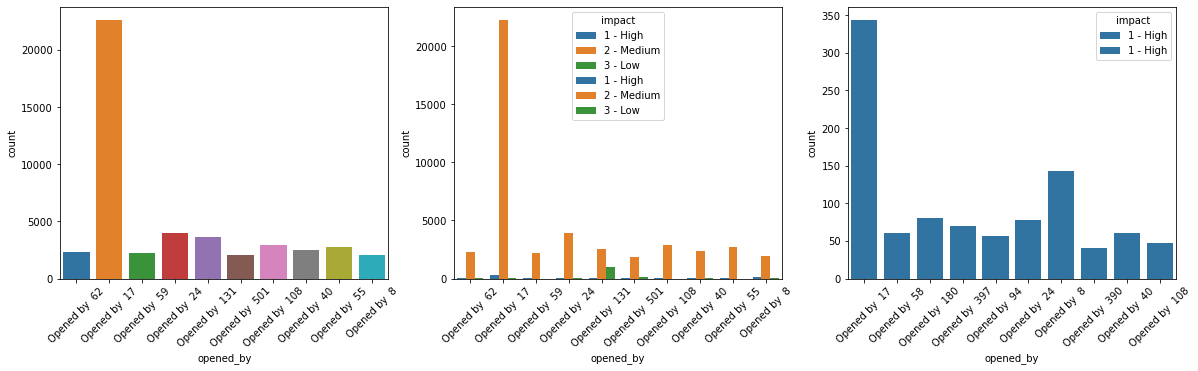

In [137]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
sns.countplot(data = X_train.loc[X_train['opened_by'].isin(top10_idopt)], x = "opened_by", ax = axes[0]).set_xticklabels(sns.countplot(data = X_train.loc[X_train['opened_by'].isin(top10_idopt)], x = "opened_by", ax = axes[0]).get_xticklabels(), rotation=45)
sns.countplot(data = X_train.loc[X_train['opened_by'].isin(top10_idopt)], x = "opened_by", hue = "impact", ax = axes[1]).set_xticklabels(sns.countplot(data = X_train.loc[X_train['opened_by'].isin(top10_idopt)], x = "opened_by", hue = "impact", ax = axes[1]).get_xticklabels(), rotation=45)
sns.countplot(data = X_train[X_train["impact"] == "1 - High"].loc[X_train['opened_by'].isin(top10_idopt_high)], x = "opened_by", hue = "impact", ax = axes[2]).set_xticklabels(sns.countplot(data = X_train[X_train["impact"] == "1 - High"].loc[X_train['opened_by'].isin(top10_idopt_high)], x = "opened_by", hue = "impact", ax = axes[2]).get_xticklabels(), rotation=45)

#### 7.6. user_symptom

In [138]:
top10_idsymp = list(X_train["user_symptom"].value_counts()[:10].index)
top10_idsymp_high = list(X_train[X_train["impact"] == "1 - High"]["user_symptom"].value_counts()[:10].index)

[Text(0, 0, 'Symptom -1'),
 Text(1, 0, 'Symptom 491'),
 Text(2, 0, 'Symptom 116'),
 Text(3, 0, 'Symptom 494'),
 Text(4, 0, 'Symptom 4'),
 Text(5, 0, 'Symptom 592'),
 Text(6, 0, 'Symptom 208'),
 Text(7, 0, 'Symptom 571'),
 Text(8, 0, 'Symptom 6'),
 Text(9, 0, 'Symptom 470')]

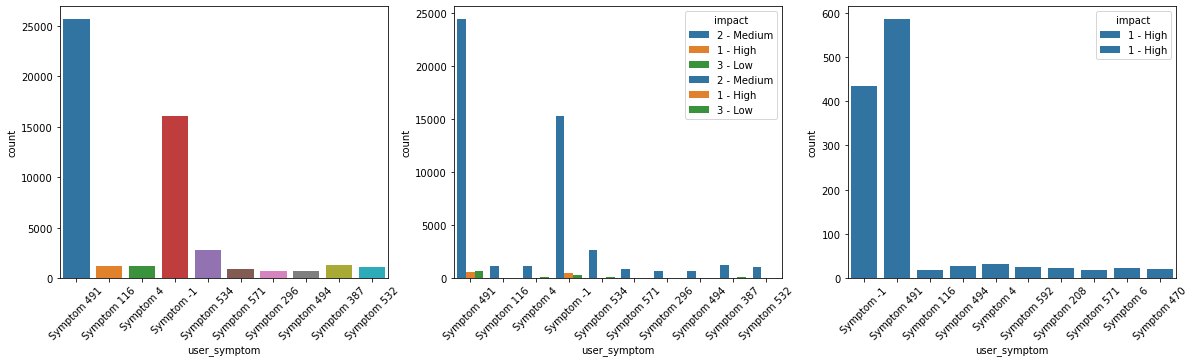

In [139]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
sns.countplot(data = X_train.loc[X_train['user_symptom'].isin(top10_idsymp)], x = "user_symptom", ax = axes[0]).set_xticklabels(sns.countplot(data = X_train.loc[X_train['user_symptom'].isin(top10_idsymp)], x = "user_symptom", ax = axes[0]).get_xticklabels(), rotation=45)
sns.countplot(data = X_train.loc[X_train['user_symptom'].isin(top10_idsymp)], x = "user_symptom", hue = "impact", ax = axes[1]).set_xticklabels(sns.countplot(data = X_train.loc[X_train['user_symptom'].isin(top10_idsymp)], x = "user_symptom", hue = "impact", ax = axes[1]).get_xticklabels(), rotation=45)
sns.countplot(data = X_train[X_train["impact"] == "1 - High"].loc[X_train['user_symptom'].isin(top10_idsymp_high)], x = "user_symptom", hue = "impact", ax = axes[2]).set_xticklabels(sns.countplot(data = X_train[X_train["impact"] == "1 - High"].loc[X_train['user_symptom'].isin(top10_idsymp_high)], x = "user_symptom", hue = "impact", ax = axes[2]).get_xticklabels(), rotation=45)

#### 7.7. support_group

In [140]:
top10_idsupg = list(X_train["Support_group"].value_counts()[:10].index)
top10_idsupg_high = list(X_train[X_train["impact"] == "1 - High"]["Support_group"].value_counts()[:10].index)

[Text(0, 0, 'Group 70'),
 Text(1, 0, 'Group 72'),
 Text(2, 0, 'Group 65'),
 Text(3, 0, 'Group 55'),
 Text(4, 0, 'Group 37'),
 Text(5, 0, 'Group 15'),
 Text(6, 0, 'Group 54'),
 Text(7, 0, 'Group 22'),
 Text(8, 0, 'Group 57'),
 Text(9, 0, 'Group 20')]

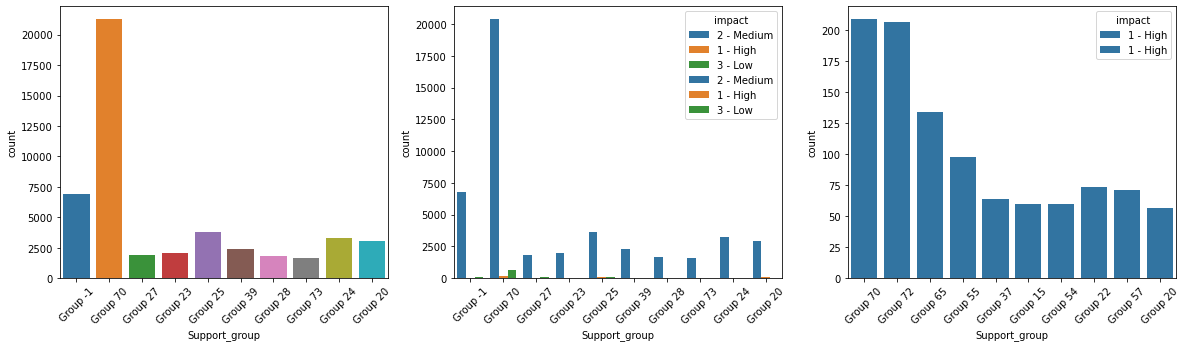

In [141]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
sns.countplot(data = X_train.loc[X_train['Support_group'].isin(top10_idsupg)], x = "Support_group", ax = axes[0]).set_xticklabels(sns.countplot(data = X_train.loc[X_train['Support_group'].isin(top10_idsupg)], x = "Support_group", ax = axes[0]).get_xticklabels(), rotation=45)
sns.countplot(data = X_train.loc[X_train['Support_group'].isin(top10_idsupg)], x = "Support_group", hue = "impact", ax = axes[1]).set_xticklabels(sns.countplot(data = X_train.loc[X_train['Support_group'].isin(top10_idsupg)], x = "Support_group", hue = "impact", ax = axes[1]).get_xticklabels(), rotation=45)
sns.countplot(data = X_train[X_train["impact"] == "1 - High"].loc[X_train['Support_group'].isin(top10_idsupg_high)], x = "Support_group", hue = "impact", ax = axes[2]).set_xticklabels(sns.countplot(data = X_train[X_train["impact"] == "1 - High"].loc[X_train['Support_group'].isin(top10_idsupg_high)], x = "Support_group", hue = "impact", ax = axes[2]).get_xticklabels(), rotation=45)

#### 7.8. support_incharge

In [142]:
top10_idsupin = list(X_train["support_incharge"].value_counts()[:10].index)
top10_idsupin_high = list(X_train[X_train["impact"] == "1 - High"]["support_incharge"].value_counts()[:10].index)

[Text(0, 0, 'Resolver 182'),
 Text(1, 0, 'Resolver -1'),
 Text(2, 0, 'Resolver 153'),
 Text(3, 0, 'Resolver 7'),
 Text(4, 0, 'Resolver 101'),
 Text(5, 0, 'Resolver 133'),
 Text(6, 0, 'Resolver 155'),
 Text(7, 0, 'Resolver 109'),
 Text(8, 0, 'Resolver 167'),
 Text(9, 0, 'Resolver 244')]

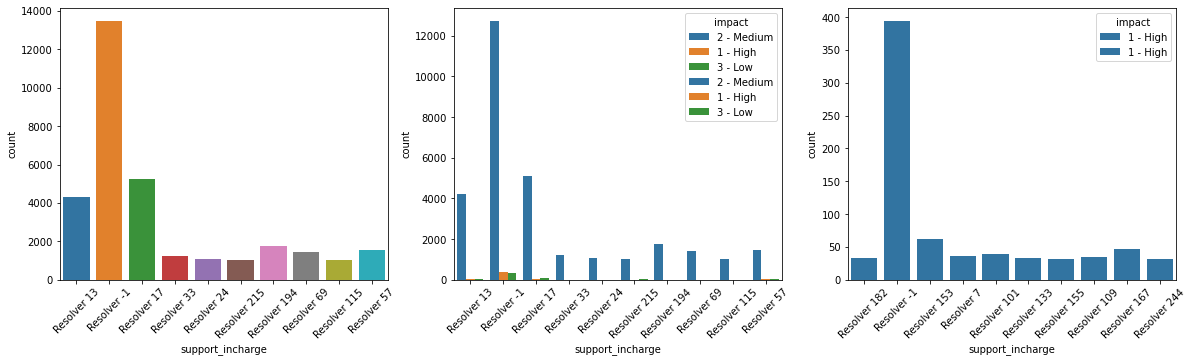

In [143]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
sns.countplot(data = X_train.loc[X_train['support_incharge'].isin(top10_idsupin)], x = "support_incharge", ax = axes[0]).set_xticklabels(sns.countplot(data = X_train.loc[X_train['support_incharge'].isin(top10_idsupin)], x = "support_incharge", ax = axes[0]).get_xticklabels(), rotation=45)
sns.countplot(data = X_train.loc[X_train['support_incharge'].isin(top10_idsupin)], x = "support_incharge", hue = "impact", ax = axes[1]).set_xticklabels(sns.countplot(data = X_train.loc[X_train['support_incharge'].isin(top10_idsupin)], x = "support_incharge", hue = "impact", ax = axes[1]).get_xticklabels(), rotation=45)
sns.countplot(data = X_train[X_train["impact"] == "1 - High"].loc[X_train['support_incharge'].isin(top10_idsupin_high)], x = "support_incharge", hue = "impact", ax = axes[2]).set_xticklabels(sns.countplot(data = X_train[X_train["impact"] == "1 - High"].loc[X_train['support_incharge'].isin(top10_idsupin_high)], x = "support_incharge", hue = "impact", ax = axes[2]).get_xticklabels(), rotation=45)

#### 7.9. category_ID

In [144]:
top10_idcatid = list(X_train["category_ID"].value_counts()[:10].index)
top10_idcatid_high = list(X_train[X_train["impact"] == "1 - High"]["category_ID"].value_counts()[:10].index)

[Text(0, 0, 'Category 46'),
 Text(1, 0, 'Category 53'),
 Text(2, 0, 'Category 23'),
 Text(3, 0, 'Category 57'),
 Text(4, 0, 'Category 19'),
 Text(5, 0, 'Category 42'),
 Text(6, 0, 'Category 45'),
 Text(7, 0, 'Category 37'),
 Text(8, 0, 'Category 26'),
 Text(9, 0, 'Category 20')]

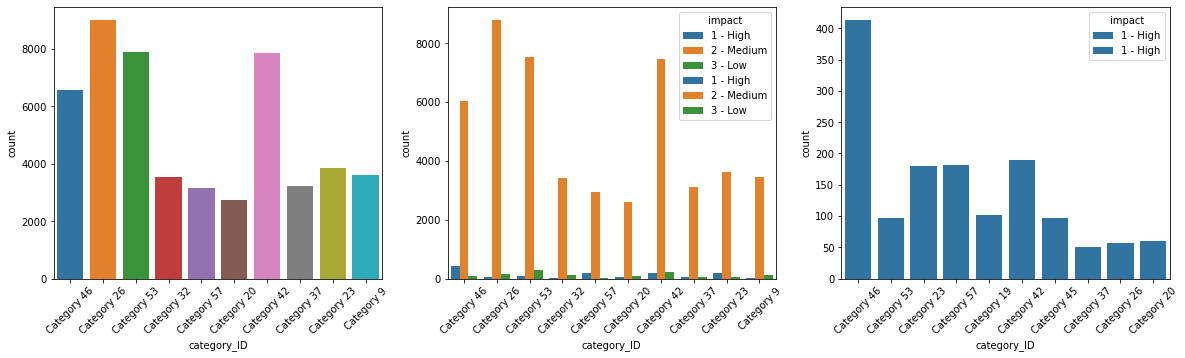

In [145]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
sns.countplot(data = X_train.loc[X_train['category_ID'].isin(top10_idcatid)], x = "category_ID", ax = axes[0]).set_xticklabels(sns.countplot(data = X_train.loc[X_train['category_ID'].isin(top10_idcatid)], x = "category_ID", ax = axes[0]).get_xticklabels(), rotation=45)
sns.countplot(data = X_train.loc[X_train['category_ID'].isin(top10_idcatid)], x = "category_ID", hue = "impact", ax = axes[1]).set_xticklabels(sns.countplot(data = X_train.loc[X_train['category_ID'].isin(top10_idcatid)], x = "category_ID", hue = "impact", ax = axes[1]).get_xticklabels(), rotation=45)
sns.countplot(data = X_train[X_train["impact"] == "1 - High"].loc[X_train['category_ID'].isin(top10_idcatid_high)], x = "category_ID", hue = "impact", ax = axes[2]).set_xticklabels(sns.countplot(data = X_train[X_train["impact"] == "1 - High"].loc[X_train['category_ID'].isin(top10_idcatid_high)], x = "category_ID", hue = "impact", ax = axes[2]).get_xticklabels(), rotation=45)

#### 8. opened_time

As we mentioned before, these variables carry valuable information. We will extract the year, the month, the day, and the hour for **opened_time**, because we believe that it is important to know in detail when the incident was opened. 

In [146]:
# We will create new columns from the opened time column for the train set
X_train['opened_time_year'] = X_train['opened_time'].dt.year
X_train['opened_time_month'] = X_train['opened_time'].dt.month
X_train['opened_time_day_of_week'] = X_train['opened_time'].dt.dayofweek
X_train['opened_time_hour'] = X_train['opened_time'].dt.hour

# We will create new columns from the opened time column for the test set
X_test['opened_time_year'] = X_test['opened_time'].dt.year
X_test['opened_time_month'] = X_test['opened_time'].dt.month
X_test['opened_time_day_of_week'] = X_test['opened_time'].dt.dayofweek
X_test['opened_time_hour'] = X_test['opened_time'].dt.hour

Now lets explore the new variables.

#### 8.1. Year

In [147]:
# years involved
X_train['opened_time_year'].value_counts()

2016    69027
2017      411
Name: opened_time_year, dtype: int64

Since there are a few observations from 2017, we will drop this variable.

#### 8.2. Month

<AxesSubplot:xlabel='opened_time_month', ylabel='count'>

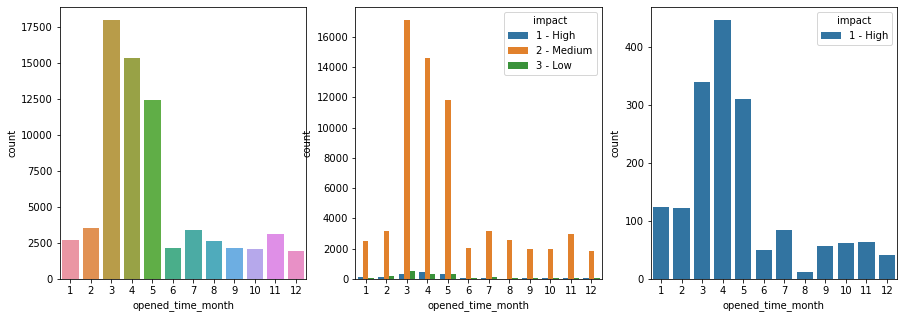

In [148]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.countplot(data = X_train, x = "opened_time_month", ax = axes[0])
sns.countplot(data = X_train, x = "opened_time_month", hue = "impact", ax = axes[1])
sns.countplot(data = X_train[X_train["impact"] == '1 - High'], x = "opened_time_month", hue = "impact", ax = axes[2])

We can see that the number of incidents peak in the period march - may. This pattern is also preserved for each type of incident. We can further extract information from this variable by grouping the march, april, may into a single label and the others into another label.

#### 8.3. Day of week

<AxesSubplot:xlabel='opened_time_day_of_week', ylabel='count'>

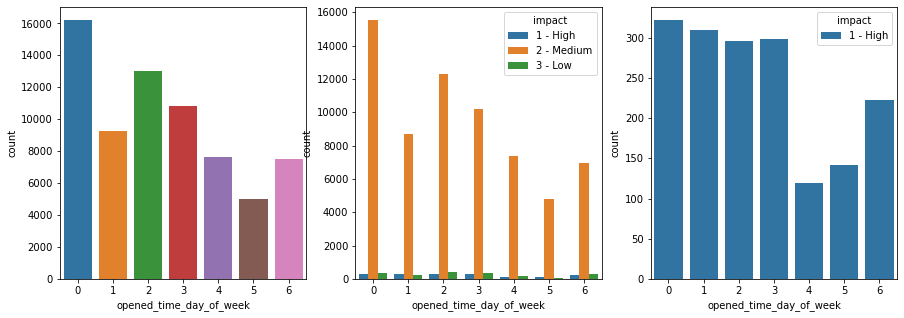

In [149]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.countplot(data = X_train, x = "opened_time_day_of_week", ax = axes[0])
sns.countplot(data = X_train, x = "opened_time_day_of_week", hue = "impact", ax = axes[1])
sns.countplot(data = X_train[X_train["impact"] == '1 - High'], x = "opened_time_day_of_week", hue = "impact", ax = axes[2])

We can observe that incidents are more likely to occur at the begining of the week. We can also create a new variable from this one by relabeling the days at the begining of the week and the days at the end of the week.

#### 8.4. Hour

<AxesSubplot:xlabel='opened_time_hour', ylabel='count'>

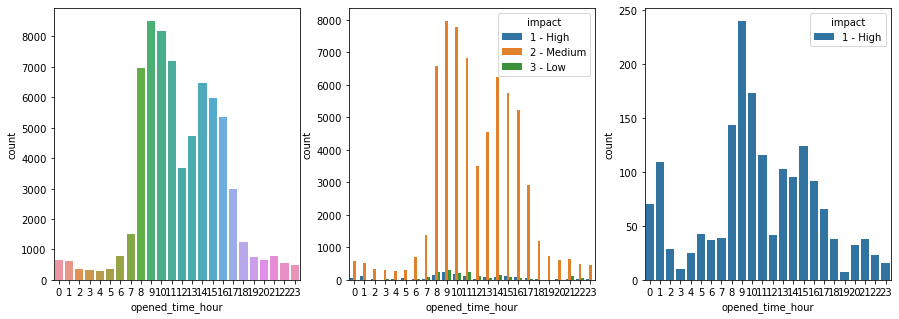

In [150]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.countplot(data = X_train, x = "opened_time_hour", ax = axes[0])
sns.countplot(data = X_train, x = "opened_time_hour", hue = "impact", ax = axes[1])
sns.countplot(data = X_train[X_train["impact"] == '1 - High'], x = "opened_time_hour", hue = "impact", ax = axes[2])

We notice that the incidents are more likey to occur during the working hours. We can further transform this variable by creating a label for working and non-working hours.

#### 9. type_contact

<AxesSubplot:xlabel='type_contact', ylabel='count'>

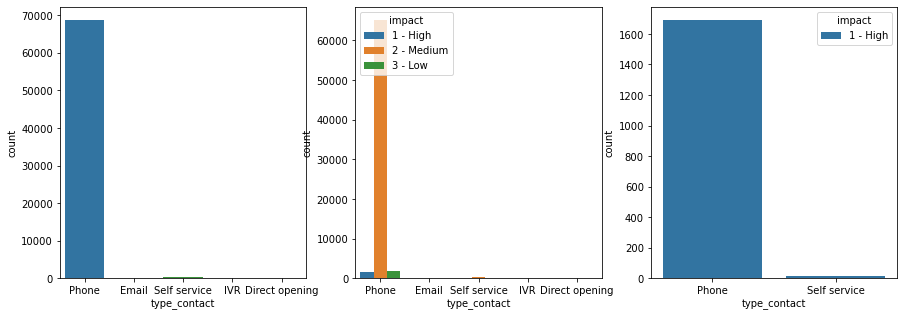

In [151]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.countplot(data = X_train, x = "type_contact", ax = axes[0])
sns.countplot(data = X_train, x = "type_contact", hue = "impact", ax = axes[1])
sns.countplot(data = X_train[X_train["impact"] == '1 - High'], x = "type_contact", hue = "impact", ax = axes[2])

We see that the main contact type is by phone. Because the other contact type represent less than 1% of the total, we will drop this column.

#### 10. Doc_knowledge

<AxesSubplot:xlabel='Doc_knowledge', ylabel='count'>

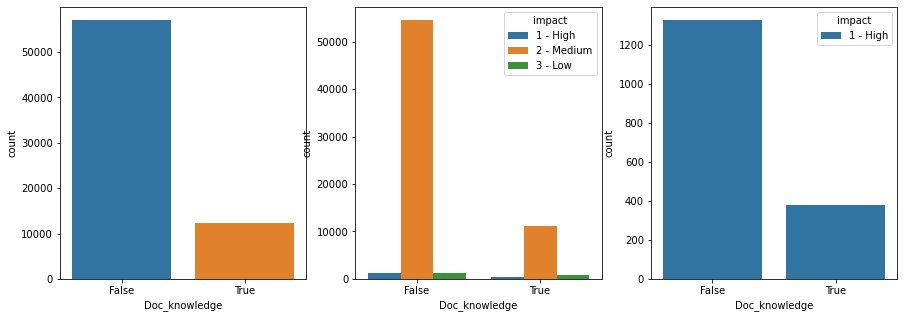

In [152]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.countplot(data = X_train, x = "Doc_knowledge", ax = axes[0])
sns.countplot(data = X_train, x = "Doc_knowledge", hue = "impact", ax = axes[1])
sns.countplot(data = X_train[X_train["impact"] == '1 - High'], x = "Doc_knowledge", hue = "impact", ax = axes[2])

#### 11. confirmation_check

<AxesSubplot:xlabel='confirmation_check', ylabel='count'>

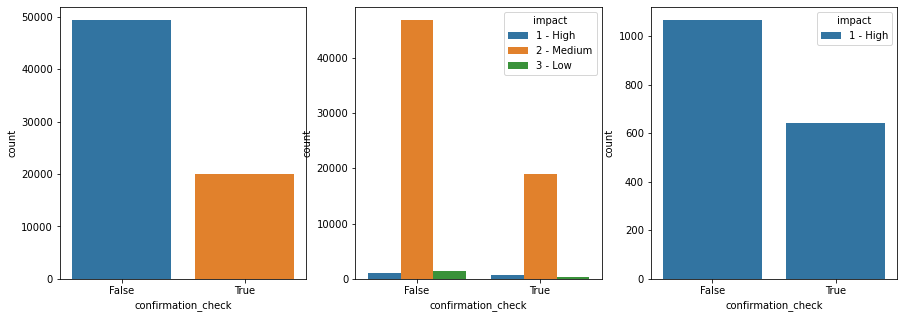

In [153]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.countplot(data = X_train, x = "confirmation_check", ax = axes[0])
sns.countplot(data = X_train, x = "confirmation_check", hue = "impact", ax = axes[1])
sns.countplot(data = X_train[X_train["impact"] == '1 - High'], x = "confirmation_check", hue = "impact", ax = axes[2])

#### 12. notify

<AxesSubplot:xlabel='notify', ylabel='count'>

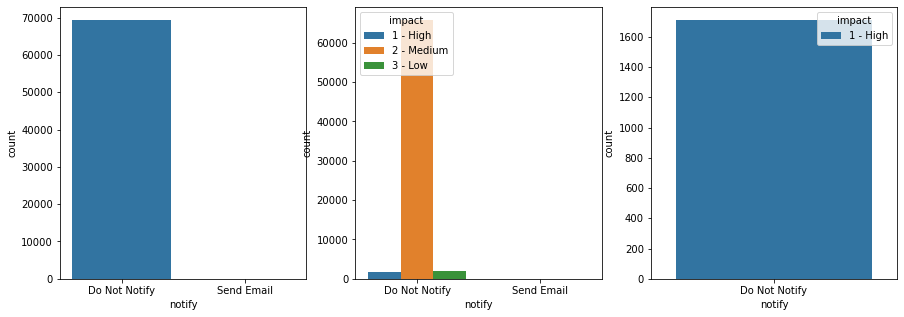

In [154]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.countplot(data = X_train, x = "notify", ax = axes[0])
sns.countplot(data = X_train, x = "notify", hue = "impact", ax = axes[1])
sns.countplot(data = X_train[X_train["impact"] == '1 - High'], x = "notify", hue = "impact", ax = axes[2])

We notice that there are very few notification generated. Therefore we can drop the entire column because it brings no new information.

## 3. Feature engineering

We take a look again at the number of unique values of the variables.

In [155]:
X_train.nunique()

ID                         23180
ID_status                      9
active                         2
count_reassign                25
count_opening                  9
count_updated                110
ID_caller                   5125
opened_by                    206
opened_time                18682
Created_by                   185
created_at                 20535
updated_by                   640
updated_at                 35629
type_contact                   5
location                     224
category_ID                   54
user_symptom                 500
Support_group                 76
support_incharge             229
Doc_knowledge                  2
confirmation_check             2
impact                         3
notify                         2
opened_time_year               2
opened_time_month             12
opened_time_day_of_week        7
opened_time_hour              24
dtype: int64

### 3.1. Boolean variables

Now we replace the labels True and False with 0 and 1.

In [156]:
for col in ["active", "Doc_knowledge", "confirmation_check"]:
    X_train[col].replace({True: 1, False:0}, inplace = True)
    X_test[col].replace({True: 1, False:0}, inplace = True)

### 3.2. Target variable: impact

We can approach the target variable in two different ways:
1. if we are solely interested in the high impact incidents, we could just regroup the medium and low incidents into a single category and transform the impact into a binary variable.
2. let the labels as they are

Because there are relatively few low impact incidents, we will consider the first approach.

In [157]:
# replacing for the training set
y_train.replace({"3 - Low": 0, "2 - Medium":0, "1 - High": 1},  inplace = True)

# replacing for the test set
y_test.replace({"3 - Low": 0, "2 - Medium":0, "1 - High": 1},  inplace = True)

### 3.3. Categorical encoding

The final step of our data processing is to encode our categorical variables. For this purpose we separate the categorical columns into a separate dataframe.

In [158]:
# categorical columns for the training set
categorical_train = X_train[["ID_status", "location", "user_symptom",  
                             "category_ID",  "opened_by"]] # "Support_group", "support_incharge"

# categorical columns for the test set
categorical_test = X_test[["ID_status", "location", "user_symptom", "category_ID", 
                          "opened_by"]] # "Support_group", "support_incharge"

Now we will drop those columns from the training and test sets.

In [159]:
X_train.drop(columns = ["ID_status", "location", "user_symptom",
                       "category_ID", "opened_by"], inplace = True)
X_test.drop(columns = ["ID_status", "location", "user_symptom",
                      "category_ID", "opened_by"], inplace = True)

We would like now to perform One Hot Encoding to our categorical variables.

In [160]:
# We use the sklearn's OneHotEncoder
OHE = OneHotEncoder(handle_unknown = "ignore",
                    sparse = False
                   )

In [161]:
# We fit the transformer on the training data
OHE.fit(categorical_train)

OneHotEncoder(handle_unknown='ignore', sparse=False)

In [162]:
# We encode our categorical variables for the training set
train_OHE = pd.DataFrame(OHE.transform(categorical_train))
train_OHE.columns = OHE.get_feature_names_out()

In [163]:
# We encode our categorical variables for the test set
test_OHE = pd.DataFrame(OHE.transform(categorical_test))
test_OHE.columns = OHE.get_feature_names_out()

We reset the index in ordere to concatenate the training and test sets with the categorical labels we created above.

In [164]:
X_train.reset_index(inplace = True)
X_test.reset_index(inplace = True)

Now we concatenate the dataframes.

In [165]:
X_train = pd.concat([X_train, train_OHE], axis = 1)
X_test = pd.concat([X_test, test_OHE], axis = 1)

Now we check if they have the same number of columns.

In [166]:
print(X_train.shape)
print(X_test.shape)

(69438, 1016)
(29760, 1016)


In [167]:
X_train.drop(columns = ["index"], inplace = True)
X_test.drop(columns = ["index"], inplace = True)

### 3.4. Droping variables

Finally, we drop the columns we do not need anymore.

In [169]:
# drop category_id, ID_caller, opened_by, created_by and updated_by columns
X_train.drop(columns = ["ID_caller",
                     "updated_by","created_at", "updated_at", "type_contact", "opened_time_year",
                        "ID", "opened_time", "Created_by", "notify", "Support_group", "support_incharge",
                        "Doc_knowledge", "confirmation_check",
                        "impact"], inplace = True)

X_test.drop(columns = ["ID_caller",
                     "updated_by","created_at", "updated_at", "type_contact", "opened_time_year",
                       "ID", "opened_time", "Created_by", "notify", "Support_group", "support_incharge",
                       "Doc_knowledge", "confirmation_check",
                      "impact"], inplace = True)

## 4. Modeling <a class="anchor" id="ml"></a>

Now we are ready to build the machine learning models. For practical purposes, we will not include in our data the values that are manually selected after an incident is raised (**Support_group**, **support_incharge**, **Doc_knowledge**, **confirmation_check**, **notify**, **Problem_id** and **change_request**), because in a real situation they would not be available. 

### 4.1. Machine learning models

We will build three different machine learning models and try to predict the high impact incidents. Then we will compare their performance and choose the one with the best performance. 

In [170]:
# Logistic Regression
logistic = LogisticRegression(max_iter = 3000, 
                              class_weight = {0:1, 1:5})

# Random Forest
rfc = RandomForestClassifier(n_estimators = 500, 
                             max_depth = 7,  class_weight = {0:1, 1:10}, 
                             n_jobs = -1)

# XGBoost
xgbc = XGBClassifier(n_estimators = 500, 
                     max_depth = 8, 
                     scale_pos_weight = 15,
                     learning_rate = 0.01,
                    n_jobs = -1)

# CatBoost
ctbc = ctb.CatBoostClassifier(n_estimators = 500,
                             learning_rate = 0.01,
                             max_depth = 8,
                             scale_pos_weight = 15)

We fit the models.

In [171]:
%%time
model_log = logistic.fit(X_train, y_train)
model_rfc = rfc.fit(X_train, y_train)
model_xgb = xgbc.fit(X_train, y_train)
model_ctb = ctbc.fit(X_train, y_train, verbose = False)

Wall time: 21min 21s


We evaluate their performance on auc and f1 scores.

Logistic regression.

In [172]:
print("ROC-AUC train:", roc_auc_score(y_train, model_log.predict(X_train)))
print("ROC-AUC test:", roc_auc_score(y_test, model_log.predict(X_test)))
print("f1 score train:", f1_score(y_train, model_log.predict(X_train)))
print("f1 score test:", f1_score(y_test, model_log.predict(X_test)))

ROC-AUC train: 0.6893223306685311
ROC-AUC test: 0.6845881035349739
f1 score train: 0.37855946398659973
f1 score test: 0.35894206549118385


Random Forest.

In [173]:
print("ROC-AUC train:", roc_auc_score(y_train, model_rfc.predict(X_train)))
print("ROC-AUC test:", roc_auc_score(y_test, model_rfc.predict(X_test)))
print("f1 score train:", f1_score(y_train, model_rfc.predict(X_train)))
print("f1 score test:", f1_score(y_test, model_rfc.predict(X_test)))

ROC-AUC train: 0.5
ROC-AUC test: 0.5
f1 score train: 0.0
f1 score test: 0.0


XGBoost.

In [174]:
print("ROC-AUC train:", roc_auc_score(y_train, model_xgb.predict(X_train)))
print("ROC-AUC test:", roc_auc_score(y_test, model_xgb.predict(X_test)))
print("f1 score train:", f1_score(y_train, model_xgb.predict(X_train)))
print("f1 score test:", f1_score(y_test, model_xgb.predict(X_test)))

ROC-AUC train: 0.8469925116302818
ROC-AUC test: 0.7506649851474314
f1 score train: 0.5537974683544304
f1 score test: 0.4249448123620309


CatBoost.

In [175]:
print("ROC-AUC train:", roc_auc_score(y_train, model_ctb.predict(X_train)))
print("ROC-AUC test:", roc_auc_score(y_test, model_ctb.predict(X_test)))
print("f1 score train:", f1_score(y_train, model_ctb.predict(X_train)))
print("f1 score test:", f1_score(y_test, model_ctb.predict(X_test)))

ROC-AUC train: 0.7524974500326831
ROC-AUC test: 0.7053999120450072
f1 score train: 0.45433847710599545
f1 score test: 0.37760571768910073


The winner is XGBoost. Further we will improve this model to obtain a better performance on auc and f1 scores.

### 4.2. Feature importance

At the previous step we built a model using all the features. It is very likely that not all features are important in predicting the incidence impact.

In [228]:
features = pd.Series(model_xgb.feature_importances_, index = X_train.columns).sort_values(ascending = False)

In [229]:
features

category_ID_Category 19     0.015781
category_ID_Category 26     0.011659
category_ID_Category 46     0.011266
user_symptom_Symptom 6      0.010795
ID_status_New               0.010793
                              ...   
user_symptom_Symptom 373    0.000000
user_symptom_Symptom 374    0.000000
user_symptom_Symptom 376    0.000000
user_symptom_Symptom 377    0.000000
user_symptom_Symptom 388    0.000000
Length: 1000, dtype: float32

No handles with labels found to put in legend.


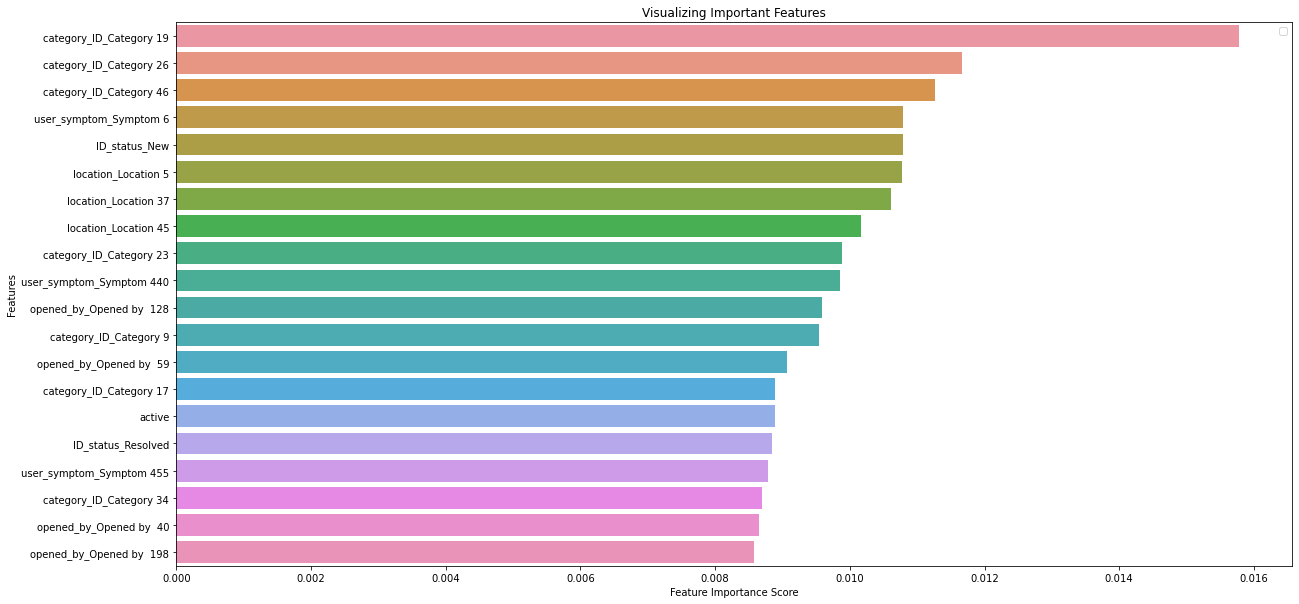

In [308]:
plt.figure(figsize = (20,10))
sns.barplot(x = features.head(20), y = features.head(20).index)

plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Visualizing Important Features')
plt.legend()
plt.show()

We see that support groups have a higher importance than other variables.

In [231]:
final_features = features[features > 0].index
len(final_features)

245

Now lets train the model again with the features we have selected.

In [395]:
# Manual hyperparameter tuning
xgb_final = XGBClassifier(n_estimators = 900, 
                     max_depth = 9, 
                     scale_pos_weight = 9,
                     learning_rate = 0.1,
                     subsample = 0.75,
                     gamma = 0.15,
                     colsample_bytree = 0.75, 
                     min_child_weight = 2,
                     max_delta_step = 3,
                     n_jobs = -1)

In [396]:
%%time
model_xgb_final = xgb_final.fit(X_train[final_features], y_train)

Wall time: 4min 13s


In [397]:
print("ROC-AUC train:", roc_auc_score(y_train, model_xgb_final.predict(X_train[final_features])))
print("ROC-AUC test:", roc_auc_score(y_test, model_xgb_final.predict(X_test[final_features])))
print("f1 score train:", f1_score(y_train, model_xgb_final.predict(X_train[final_features])))
print("f1 score test:", f1_score(y_test, model_xgb_final.predict(X_test[final_features])))

ROC-AUC train: 0.9993798632746171
ROC-AUC test: 0.9069342975639513
f1 score train: 0.9760410724472333
f1 score test: 0.8168822328114362


## 5. Evaluation <a class="anchor" id="eval"></a>

Our goal is to predict the **high impact incidents**. 

### 5.1. Performance assessment

We would like now to evaluate the model's performance and the impact of it on the business problem. Since we deal with an imbalanced classes, we cannot rely on accuracy score. Therefore, we will look at the **precision**, **recall** and **f1_score**.

Precision and recall are derived from the confusion matrix, which is a summary of the prediction results. For our training and test sets there confusion matrices are:

In [398]:
# train set
print(confusion_matrix(y_train, model_xgb_final.predict(X_train[final_features])))

[[67643    84]
 [    0  1711]]


In [399]:
# test set
print(confusion_matrix(y_test, model_xgb_final.predict(X_test[final_features])))

[[28891   136]
 [  133   600]]


**Precision** is a measure for how good the algorithm is at predicting the right class.

$$\text{precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}} $$

**Recall** is a measure of how many relevant incidents were detected.

$$\text{recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}} $$

In our setting, a higher precision means that we correctly identify the impact of the incidents (i.e. we do not classify other incidents as high when in fact they are not), whereas a higher recall means that we do not missclassify the impact of the incidents (i.e. classifing an incident as having a medium impact when in fact it is high).


Since we care for both metrics, we want to obtain high measures for both. In this case we will use the **f1 score**, which combines both metrics and is given by the formula:

$$ \text{f1} = \frac{2 \times \text{precision} \times \text{recall}}{\text{precision} + \text{recall} } $$




In [400]:
print(classification_report(y_train, model_xgb_final.predict(X_train[final_features])))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     67727
           1       0.95      1.00      0.98      1711

    accuracy                           1.00     69438
   macro avg       0.98      1.00      0.99     69438
weighted avg       1.00      1.00      1.00     69438



In [401]:
print(classification_report(y_test, model_xgb_final.predict(X_test[final_features])))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29027
           1       0.82      0.82      0.82       733

    accuracy                           0.99     29760
   macro avg       0.91      0.91      0.91     29760
weighted avg       0.99      0.99      0.99     29760



From the above classification report we can see that our model has:
- **82% precision** - correctly classifies the incidents as high 82% of the time
- **82%  recall** - correctly classifies the incidents as not high 82% of the time. 
- overall an **f1 score** of 0.82 

By looking at the f1 score for the training and test sets we can see that there is overfitting. If we want our model to yield good results in production we should try to reduce the overfitting.

### 5.2. SHAP

In the previous section we have seen that some features weight more than others. Now we will understand how our features impact the predictions of the model.

In [405]:
explainer = shap.TreeExplainer(model_xgb_final)

In [406]:
# We calculate the shap values
shap_values = explainer.shap_values(X_test[final_features])

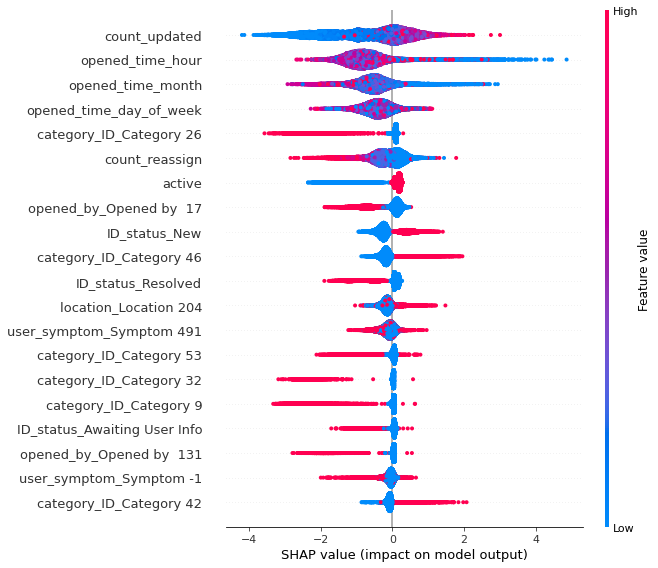

In [407]:
# We plot the feature importance 
shap.summary_plot(shap_values, X_test[final_features], max_display = 20)

From the above graphic we can see the impact of the features' values on the model's prediction. Only the first 20 features were plotted.In case you want to see them all, just set the parameter *max_display* to the number of all features.

On this plot we have two dimensions: the value of the features and the impact on model output. Lets have a closer look. For example: 
- **count_updated**: the lower the number updates of an incident, the lesser impact on the output has
- **opened_time_hour**: the hour has values between 0 and 23. The incidents closer to the midnight have a higher impact
- **opened_time_month**: the closer to the begining of the year the incident is opened, the more impact has on the output
- **opened_time_day_of_week**: this variable beings with 0 - Monday and ends with 6 - Sunday; it seems that incidents opened at the middle of the week have a lower impact on the output, whereas the weekend seem to have both a positive and negative impact, depending on the day (perhaps Sunday has a positive impact)
- **category_ID_Category_26**: since it is has only 0 and 1 values, has a lower impact on hte output; the same interpretation for other binary variables;

## 6. Conclusions <a class="anchor" id="conclusions"></a>

In this notebook our goal was to build a machine learning solution for predicting the impact of the incidents in order to improve the incident management process. We built a Machine Learning model that has an f1 score of 82%. Although there are clear signs of overfitting, we have shown that it is possible with the available data to predict the impact of an incident and the model can be further improved.